In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Bibliografía:


https://keras.io/api/preprocessing/image/

https://www.tensorflow.org/tutorials/images/classification#compile_the_model

https://keras.io/examples/vision/image_classification_from_scratch/

https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/


https://www.tensorflow.org/guide/keras/save_and_serialize?hl=es-419

https://torres.ai/data-augmentation-y-transfer-learning-en-keras-tensorflow/#Fine_Tuning

In [ ]:
!ls /content/drive

MyDrive


In [ ]:
!unzip '/content/drive/MyDrive/IA/train.zip' -d '/content/Data'#Descomprimimos la carpeta con las imágenes

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/Data/Baroque architecture/2415_450px-Michaelerkirche_Vienna_June_2006_326.jpg  
  inflating: /content/Data/Baroque architecture/180_800px-Besilica_of_Bom_Jesus_5%28Old_Goa_%29.jpg  
  inflating: /content/Data/Baroque architecture/003839.jpg  
  inflating: /content/Data/Baroque architecture/003452.jpg  
  inflating: /content/Data/Baroque architecture/3398_386px-Deutscher_Dom_Berlin_Gendarmenmarkt_december_2004.jpg  
  inflating: /content/Data/Baroque architecture/003739.jpg  
  inflating: /content/Data/Baroque architecture/580_450px-Santa_Maria_della_Salute.JPG  
  inflating: /content/Data/Baroque architecture/003420.jpg  
  inflating: /content/Data/Baroque architecture/582_450px-Wenecja_Santa_Maria_della_Salute.JPG  
  inflating: /content/Data/Baroque architecture/003415.jpg  
  inflating: /content/Data/Baroque architecture/4388_453px-Church_of_the_Merciful_Saviour_in_Kuskovo_14.jpg  
  inflating: /conte

In [ ]:
import tensorflow 
from tensorflow import keras as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential #Llevamos a cabo todas las importaciones que vamos a necesitar para leer atos y contruir el modelo

In [ ]:
#Esta es la parte del código que se encarga del preprocesado de las imágenes
directory = "/content/Data" #Al haber descomprimido la carpeta en este directorio, esta es la ruta que debemos indicar para la lectura de las imágenes

val= tf.preprocessing.image_dataset_from_directory(#Conjunto de validación
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),#Es necesario que las imágenes se procesen en un mismo tamaño, que escogimos de forma arbitraria
    shuffle=True,
    seed=1234,#semilla elegida de forma arbitraria
    validation_split=0.25, #división al 25%
    subset="validation",#se indica que esta división pertenece al conjunto de validación
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

train= tf.preprocessing.image_dataset_from_directory(#Conjunto de entenamiento
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=1234,#semilla elegida de forma arbitraria
    validation_split=0.25, #Indicamos que el 25% del conjunto va destinado a validar (por tanto, el 75% será de entrenamiento)
    subset="training",#se indica que esta división pertenece al conjunto de entrenamiento
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

Found 7068 files belonging to 25 classes.
Using 1767 files for validation.
Found 7068 files belonging to 25 classes.
Using 5301 files for training.


In [ ]:
#Comprobamos que se han leído correctamente los nombres de los estilos arquitectónicos
class_names = train.class_names
print(class_names)
print(len(class_names))#comprobamos que son 25

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']
25


In [ ]:
#Generamos imágenes extra del conjunto de prueba a partir de las que ya teníamos
data_augmentation = tf.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(256, 
                                                              256,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1), #Rotación y aumento aleatorios
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


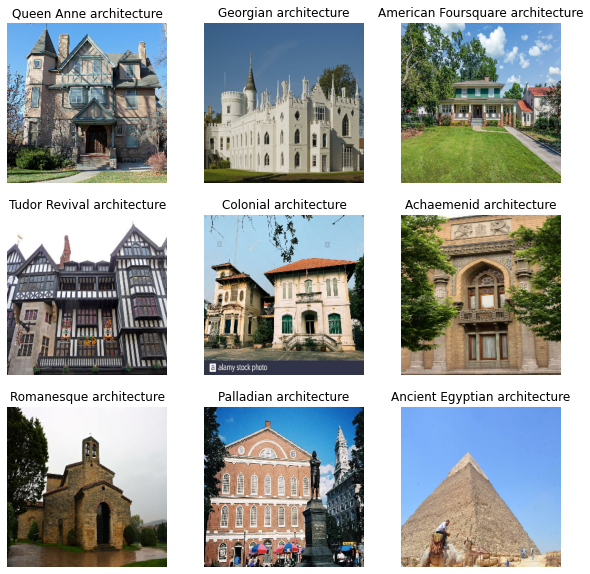

In [ ]:
#Comprobamos que las imágenes y sus clasificaciones se han preprocesado correctamente imprimiendo por pantallas un subconjunto de ellas

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])#En vez de su clasificación como número, buscamos su nombre en la lista de clases en la posición correspondiente a i
        plt.axis("off")

Mejor modelo (Convolución + dropout + número óptimo de nodos)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,#Datos extra para evitar sobreajuste
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),#normalización de los valores de las matrices rgb
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),#4 pares de conv y maxpooling, para reducir el número de detalles
  layers.MaxPooling2D(),
  layers.Dropout(0.8),#Capa dropout, de nuevo para evitar sobreajuste
  layers.Flatten(),
  layers.Dense(80, activation='relu'),#La última capa oculta tiene ahora 80 nodos
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',#compilamos el modelo.
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()#Para ver la estructura de la red de forma más ordenada y los parámetros entrenables

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [ ]:
epochs=100 #Definimos el número de épocas que durará el entrenamiento. En este caso 100, para asegurarnos de que queda bien entrenado
history = model.fit(#entrenamos el modelo dado el conjunto de entrenamiento train y el de validación val
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/100
166/166 [==============================] - 62s 175ms/step - loss: 3.1950 - accuracy: 0.0668 - val_loss: 3.1626 - val_accuracy: 0.0481
Epoch 2/100
166/166 [==============================] - 29s 170ms/step - loss: 3.1036 - accuracy: 0.0911 - val_loss: 2.9440 - val_accuracy: 0.1307
Epoch 3/100
166/166 [==============================] - 29s 171ms/step - loss: 2.9182 - accuracy: 0.1377 - val_loss: 2.9805 - val_accuracy: 0.1313
Epoch 4/100
166/166 [==============================] - 29s 172ms/step - loss: 2.8546 - accuracy: 0.1513 - val_loss: 2.7515 - val_accuracy: 0.1794
Epoch 5/100
166/166 [==============================] - 29s 171ms/step - loss: 2.7908 - accuracy: 0.1647 - val_loss: 2.8474 - val_accuracy: 0.1454
Epoch 6/100
166/166 [==============================] - 29s 170ms/step - loss: 2.7323 - accuracy: 0.1809 - val_loss: 2.6746 - val_accuracy: 0.1868
Epoch 7/100
166/166 [==============================] - 29s 170ms/step - loss: 2.6783 - accuracy: 0.1885 - val_loss: 2.6185 -

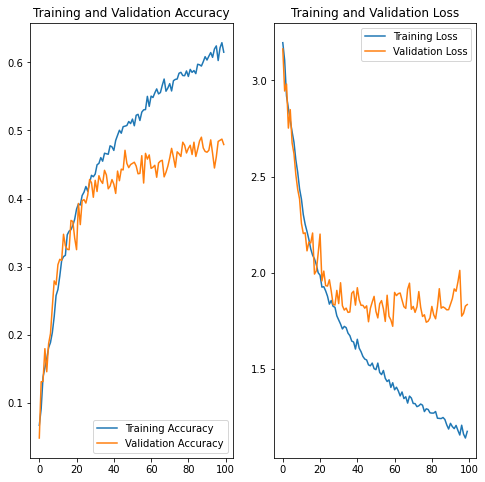

In [ ]:
#Contruimos dos gráficas que compararán el modelo respecto al conjunto de entrenamiento y el de validación a lo largo de las etapas de su entrenamiento

#Para la gráfica de validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Para la gráfica de pérdida
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#Definimos las etiquetas de la gráfica, para que se pueda entender correctamente

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) #Para poder mostrar dos gráficas en la misma imagen, posición 1
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) #Para poder mostrar dos gráficas en la misma imagen, posición 2
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Para comprobar cómo se clasificará una imagen concreta mediante nuestro modelo:

#Preprocesamos la imagen, indicando su ubicación dentro de Drive y su tamaño: ancho, largo y profundidad
img = tf.preprocessing.image.load_img(
    "/content/Data/Bauhaus architecture/165_400px-Bad_Nauheim_Synagoge_97.JPG", target_size=(256,256,3) 
)
#transformamos la imagen en un array
img_array = tf.preprocessing.image.img_to_array(img)
img_array = tensorflow.expand_dims(img_array, 0)  

#Mediante predict, obtenemos la clasificación que hace nuestro modelo para la imagen
predictions = model.predict(img_array)

#Obtenemos la clase (nodo de la capa final) para la cuál se ha obtenido mayor valor en la clasificación
score = predictions[0]
print(
    class_names[score.tolist().index(max(score))]#para obtener el nombre de la clase, accedemos a la posición iésima de la lista de nombres que generamos tras preprocesar los datos
)

Bauhaus architecture


In [ ]:
model.save('/content/drive/MyDrive/IA/mejorModelo.h5')

Modelo peor (no tiene convolución buena, dropout ni aumento de datos)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(80, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)       

In [ ]:
epochs=100
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/100
166/166 [==============================] - 29s 170ms/step - loss: 3.1883 - accuracy: 0.0715 - val_loss: 3.0346 - val_accuracy: 0.1200
Epoch 2/100
166/166 [==============================] - 29s 169ms/step - loss: 2.8804 - accuracy: 0.1585 - val_loss: 2.7417 - val_accuracy: 0.1851
Epoch 3/100
166/166 [==============================] - 29s 169ms/step - loss: 2.4703 - accuracy: 0.2586 - val_loss: 2.6965 - val_accuracy: 0.2218
Epoch 4/100
166/166 [==============================] - 28s 168ms/step - loss: 1.8827 - accuracy: 0.4243 - val_loss: 2.8258 - val_accuracy: 0.2349
Epoch 5/100
166/166 [==============================] - 29s 168ms/step - loss: 1.1763 - accuracy: 0.6361 - val_loss: 3.8085 - val_accuracy: 0.2009
Epoch 6/100
166/166 [==============================] - 29s 170ms/step - loss: 0.6238 - accuracy: 0.8102 - val_loss: 4.6882 - val_accuracy: 0.2122
Epoch 7/100
166/166 [==============================] - 29s 169ms/step - loss: 0.3140 - accuracy: 0.9117 - val_loss: 5.4186 -

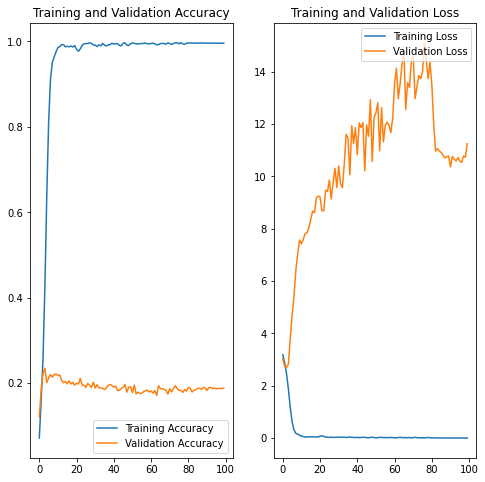

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img = tf.preprocessing.image.load_img(
    "/content/Data/Bauhaus architecture/165_400px-Bad_Nauheim_Synagoge_97.JPG", target_size=(256,256,3)
)
img_array = tf.preprocessing.image.img_to_array(img)
img_array = tensorflow.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    class_names[score.tolist().index(max(score))]
)

Bauhaus architecture


In [ ]:
model.save('/content/drive/MyDrive/IA/peorModelo.h5')

Modelo sin dropout

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(80, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
epochs=100
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/100
166/166 [==============================] - 30s 171ms/step - loss: 3.2019 - accuracy: 0.0647 - val_loss: 3.1839 - val_accuracy: 0.0713
Epoch 2/100
166/166 [==============================] - 29s 171ms/step - loss: 3.1528 - accuracy: 0.0789 - val_loss: 3.0406 - val_accuracy: 0.1239
Epoch 3/100
166/166 [==============================] - 29s 170ms/step - loss: 2.9789 - accuracy: 0.1309 - val_loss: 2.8307 - val_accuracy: 0.1664
Epoch 4/100
166/166 [==============================] - 29s 169ms/step - loss: 2.8714 - accuracy: 0.1507 - val_loss: 2.7935 - val_accuracy: 0.1715
Epoch 5/100
166/166 [==============================] - 29s 170ms/step - loss: 2.7759 - accuracy: 0.1726 - val_loss: 2.7553 - val_accuracy: 0.1873
Epoch 6/100
166/166 [==============================] - 29s 169ms/step - loss: 2.6805 - accuracy: 0.2043 - val_loss: 2.6285 - val_accuracy: 0.2173
Epoch 7/100
166/166 [==============================] - 29s 169ms/step - loss: 2.5907 - accuracy: 0.2262 - val_loss: 2.6174 -

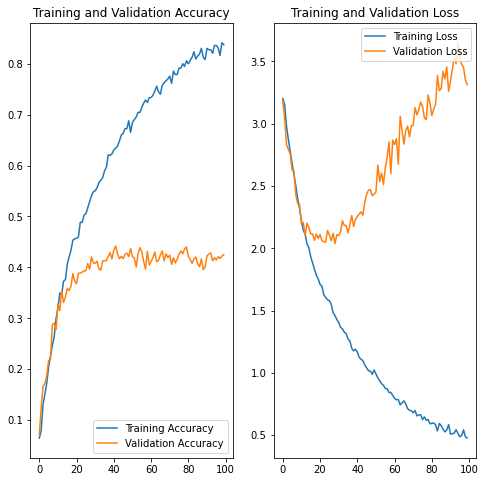

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img = tf.preprocessing.image.load_img(
    "/content/Data/Bauhaus architecture/165_400px-Bad_Nauheim_Synagoge_97.JPG", target_size=(256,256,3)
)
img_array = tf.preprocessing.image.img_to_array(img)
img_array = tensorflow.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    class_names[score.tolist().index(max(score))]
)

Bauhaus architecture


In [ ]:
model.save('/content/drive/MyDrive/IA/sinDropout.h5')

Modelo sin número adecuado de convoluciones

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.8),
  layers.Flatten(),
  layers.Dense(80, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
epochs=100
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img = tf.preprocessing.image.load_img(
    "/content/Data/Bauhaus architecture/165_400px-Bad_Nauheim_Synagoge_97.JPG", target_size=(256,256,3)
)
img_array = tf.preprocessing.image.img_to_array(img)
img_array = tensorflow.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    class_names[score.tolist().index(max(score))]
)

In [ ]:
model.save('/content/drive/MyDrive/IA/sinConvolución.h5')

Modelo sin aumento de datos

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.8),
  layers.Flatten(),
  layers.Dense(80, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)       

In [ ]:
epochs=100
history = model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/100
166/166 [==============================] - 62s 176ms/step - loss: 3.2080 - accuracy: 0.0617 - val_loss: 3.1853 - val_accuracy: 0.0713
Epoch 2/100
166/166 [==============================] - 29s 171ms/step - loss: 3.1620 - accuracy: 0.0781 - val_loss: 3.0786 - val_accuracy: 0.0911
Epoch 3/100
166/166 [==============================] - 29s 172ms/step - loss: 2.9591 - accuracy: 0.1270 - val_loss: 2.8822 - val_accuracy: 0.1387
Epoch 4/100
166/166 [==============================] - 29s 174ms/step - loss: 2.8176 - accuracy: 0.1683 - val_loss: 2.6891 - val_accuracy: 0.2043
Epoch 5/100
166/166 [==============================] - 29s 174ms/step - loss: 2.6571 - accuracy: 0.2073 - val_loss: 2.6232 - val_accuracy: 0.2088
Epoch 6/100
166/166 [==============================] - 29s 173ms/step - loss: 2.4931 - accuracy: 0.2581 - val_loss: 2.4254 - val_accuracy: 0.2694
Epoch 7/100
166/166 [==============================] - 29s 172ms/step - loss: 2.3348 - accuracy: 0.2998 - val_loss: 2.3546 -

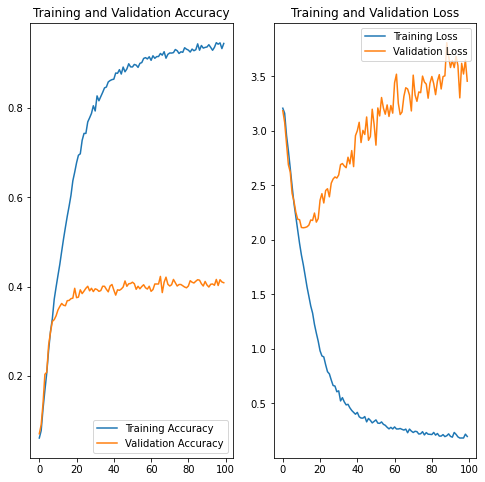

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img = tf.preprocessing.image.load_img(
    "/content/Data/Bauhaus architecture/165_400px-Bad_Nauheim_Synagoge_97.JPG", target_size=(256,256,3)
)
img_array = tf.preprocessing.image.img_to_array(img)
img_array = tensorflow.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    class_names[score.tolist().index(max(score))]
)

In [ ]:
model.save('/content/drive/MyDrive/IA/sinAumentoDatos.h5')